# Convolutional Neural Network using Sentinel 2 for the classification of landcover within South Dakota

This notebooknotebook sits alongside the masters thesis for Andrew Holden submitted as part of his stuidies towards a Masters in Geographical Information Management at Cranfield University. 


## Configure the Environment

In [1]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image
from functools import reduce
import h5py
import seaborn as sns
from ee_datasets import ee_datasets
import seaborn as sns
import sklearn

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network

In [2]:
ee.Initialize()

## Starting Parameters

In [3]:
# epochs
epc = 5
# land cover categories
cls = 8
#batch size
bth = 64
#number of bands 
bnd = 6
#number of nodes/neurons
node = 512
node2 = 512

# Start and stop of time series
startDate = ee.Date('2016-08-01')
stopDate  = ee.Date('2016-08-30')

#CDL dates- just change the year
startDateCrop = ee.Date('2016-01-01')
stopDateCrop  = ee.Date('2016-12-31')

#chart titles
titles = ['Corn', 'Soy', 'Urban', 'Alfalfa','Other Hay','Water','Grass','Other']
titlesx=['Blue', 'Green', 'Red', 'NIR', 'NDVI', 'NDWI']

# Central position of (AOIs) - both containing a large amount of corn and soybean acres
points = [[-96.8389, 44.43378], [-97.580566, 43.678301]]

# Central position of (AOIs) - one hay and one corn/beans
#points = [[-102.5463, 44.6842], [-97.580566, 43.678301]]

# Central position of (AOIs) - Dell Rapids - South Dakota
point2 = [-96.61651, 43.933506]

# Central position of (AOIs) - Pierre - South Dakota
#point2 = [-100.362854, 44.371314]

**Functions**

In [4]:
def display_image(image, region, Vizz = None):
    """
    Displays images in notebook
    """ 
    ## Visualization
    if Vizz:
        image = image.visualize(**Vizz)
        
    visual = Image(url=image.getThumbUrl({
                'region':region
                }))
    
    display(visual)

In [5]:
def CloudMaskS2(image):
    """
    European Space Agency (ESA) clouds from 'QA60', i.e. Quality Assessment band at 60m
    parsed by Nick Clinton
    """
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = int(2**10)
    cirrusBitMask = int(2**11)

    # Both flags set to zero indicates clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
            qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

In [6]:
def CloudFreeCompositeS2(Collection_id, startDate, stopDate, geom):
    ## Define your collection
    collection = ee.ImageCollection(Collection_id)

    ## Filter 
    collection = collection.filterBounds(geom).filterDate(startDate,stopDate)\
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
            .map(CloudMaskS2)

    ## Composite
    composite = collection.median()
    
    return composite

## Sentinel 2  
### Sentinel-2 MSI: MultiSpectral Instrument, Level-1C ([gee](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2))
**Dataset Availability**: 2015-06-23T00:00:00 - Present

**Wavebands**

|Band 	|Use 		|Wavelength (nm) |Resolution (m)|
|-------|-----------|----------------|--------------|
|B1 	|Aerosols 	|443 	|60|
|B2 	|Blue 		|490 	|10|
|B3 	|Green 		|560 	|10|
|B4 	|Red 		|665 	|10|
|B6 	|Red Edge 2 |740 	|20|
|B8 	|NIR        |835 	|10|
|B8a 	|Red Edge 4 |865 	|20|
|B9 	|Water vapor|940 	|60|
|B10 	|Cirrus 	|1375 	|60|
|B11 	|SWIR 1 	|1610 	|20|
|B12 	|SWIR 2 	|2190 	|20|
|QA60   |ESA Cloud  | n/a   |60|

In [7]:
# GEE Image Collection ID
Collection_id = 'COPERNICUS/S2'

# Scale in meters
scale = 10

## Set the Area of Interest 

In [8]:
# Area of Interest (AoI)
geom = ee.Geometry.Polygon([[[-104.04, 42.988], [-96.49, 42.98],[-96.49, 45.94],[-104.04, 45.94],[-104.04, 42.98]]], None, False)
region = geom.bounds().getInfo()['coordinates']

**Cloud Free Composites of the test sites**

RGB

In [9]:
# Visualization parameters
vis = {'min':0,'max':0.3, 'bands':['B4','B3','B2']}
# Cloud Free Composite
image = CloudFreeCompositeS2(Collection_id, startDate, stopDate, geom)
# Display Composite
display_image(image, region, Vizz = vis)

## Cropland Data Layer
### USDA NASS Cropland Data Layers ([gee](https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL))

**Dataset Availability**: January 1997 - Present

**Resolution**
30 meters

**Bands**

|Name 	    |Min|Max |Description 	|
|-----------|---|----|--------------|
|cropland 	|1 	|254 |Main crop-specific land cover classification.|
|cultivated |1 	|2   |Classification layer for identifying cultivated and non-cultivated land cover. Available from 2013 to 2017.|
|confidence |0 	|100 |Per-pixel predicted confidence of the given classification, with 0 being the least confident and 100 the most confident.|

In [10]:
# GEE Image Collection ID
Collection_id = 'USDA/NASS/CDL'

Ground truth land cover classification

In [11]:
dataset = ee.ImageCollection(Collection_id)\
    .filterBounds(geom)\
    .filterDate(startDate,stopDate)

# First image
image = ee.Image(dataset.first())

# Choose the scale
image =  image.reproject(crs='EPSG:4326', scale=scale)

## Download datasets
We download and stack datasets from two different Areas of Interest (AOIs)

In [12]:
#from ee_datasets import ee_datasets

for n, point in enumerate(points):
    sentinel = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
    cropland = ee_datasets(point = point, buffer = 10000 , startDate = startDateCrop, stopDate = stopDateCrop, scale = scale, collection = 'CroplandDataLayers')
    dataset_x = sentinel.read_datasets()
    dataset_y = cropland.read_datasets()
    if n == 0:
        data_x = dataset_x
        data_y = dataset_y
    else:
        szy1, szx1 = data_x.shape[:2]
        szy2, szx2 = dataset_x.shape[:2]
        if szy1 != szy2 or szx1 != szx2:
            szy = min(szy1, szy2)
            szx = min(szx1, szx2)
            
            data_x = np.stack((data_x[:szy,:szx,:], dataset_x[:szy,:szx,:]), axis=0)
            data_y = np.stack((data_y[:szy,:szx,:], dataset_y[:szy,:szx,:]), axis=0)
        else:
            data_x = np.stack((data_x, dataset_x), axis=0)
            data_y = np.stack((data_y, dataset_y), axis=0)

**Display channels**

We display the input and output datasets

In [13]:
def display_channels(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

In [14]:
def display_channels_4(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

Sentinel 2 composite for the for the fist AOI

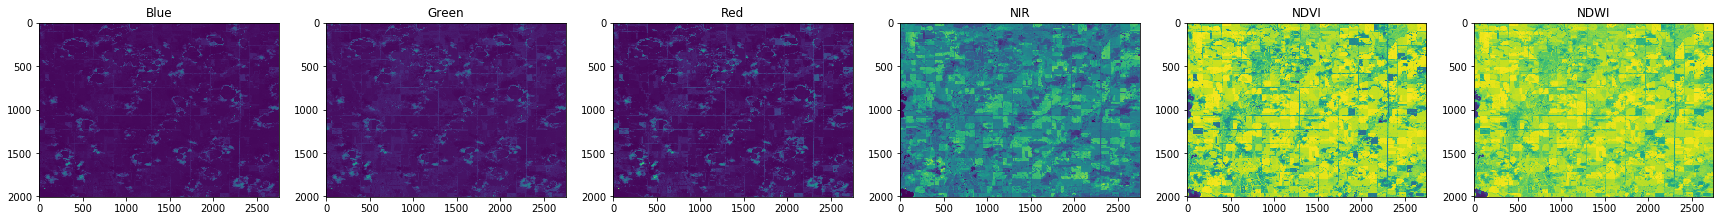

In [15]:
display_channels(data_x[0,:,:,:], data_x.shape[3], titles=titlesx)

Ground truth land cover classification for the for the fist AOI

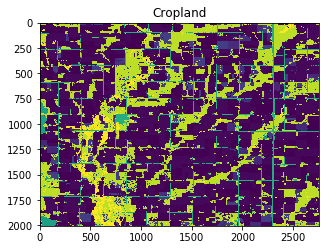

In [16]:
display_channels(data_y[0,:,:,:], data_y.shape[3], titles=['Cropland'])

Sentinel 2 composite for the for the second AOI

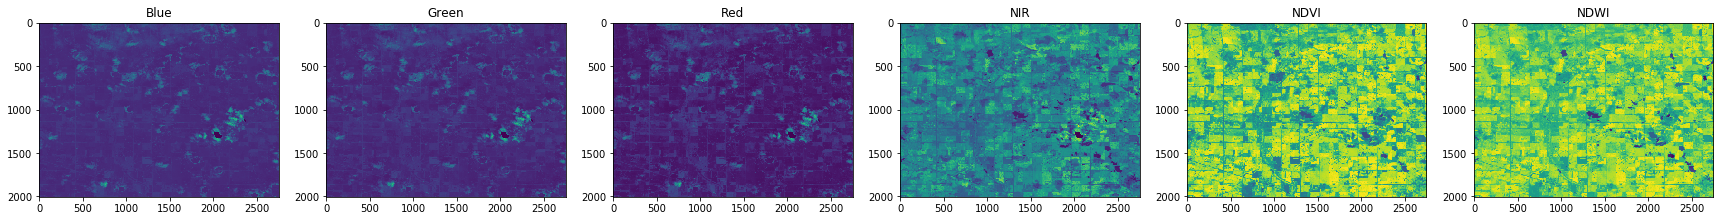

In [17]:
display_channels(data_x[1,:,:,:], data_x.shape[3], titles=titlesx)

Ground truth land cover classification for the for the second AOI

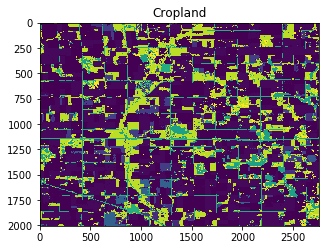

In [18]:
display_channels(data_y[1,:,:,:], data_y.shape[3], titles=['Cropland'])

## Preprocess class labels

Each class in encoded as a value in the range between 0 to 254. For training a Neural Network in Keras we have to convert the 1-dimensional class arrays to N classes-dimensional matrices. To simplify the problem here we regroup all the classes into 8 categories.

In [19]:
# Area of Interest (AoI)
geom = ee.Geometry.Point(points[0]).buffer(10000)

# Read the ImageCollection
dataset = ee.ImageCollection('USDA/NASS/CDL')\
    .filterBounds(geom)\
    .filterDate(startDateCrop,stopDateCrop)
# Get the cropland class values and names
cropland_info = pd.DataFrame({'cropland_class_values':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_values'),
                              'cropland_class_palette':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_palette'),
                              'cropland_class_names':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_names')
                             })
cropland_info.head()

,cropland_class_names,cropland_class_palette,cropland_class_values
0,Background,000000,0.0
1,Corn,ffd300,1.0
2,Cotton,ff2626,2.0
3,Rice,00a8e5,3.0
4,Sorghum,ff9e0c,4.0


The number of unique classes in this are is equal to:

In [20]:
len(np.unique(data_y[:,:,:,0]))

28

and the number of pixels by class

In [21]:
value, count = np.unique(data_y[0,:,:,0], return_counts=True)
df = pd.DataFrame({'cropland_class_values': value, 'cropland_class_counts': count})
df.sort_values(by='cropland_class_counts', ascending=False, inplace=True)
df = pd.merge(df, cropland_info, how='left', on=['cropland_class_values'])
df.head()

,cropland_class_counts,cropland_class_values,cropland_class_names,cropland_class_palette
0,1763951,1.0,Corn,ffd300
1,1603452,5.0,Soybeans,267000
2,1238444,176.0,Grassland/Pasture,e8ffbf
3,229862,121.0,Developed/Open Space,9b9b9b
4,164594,195.0,Herbaceous Wetlands,7fb2b2


In [22]:
value, count = np.unique(data_y[1,:,:,0], return_counts=True)
df = pd.DataFrame({'cropland_class_values': value, 'cropland_class_counts': count})
df.sort_values(by='cropland_class_counts', ascending=False, inplace=True)
df = pd.merge(df, cropland_info, how='left', on=['cropland_class_values'])
df.head()

,cropland_class_counts,cropland_class_values,cropland_class_names,cropland_class_palette
0,2013667,1.0,Corn,ffd300
1,1612165,5.0,Soybeans,267000
2,873435,176.0,Grassland/Pasture,e8ffbf
3,246536,121.0,Developed/Open Space,9b9b9b
4,229362,111.0,Open Water,4c70a3


In [23]:
# formula to change the class labels
def replace_values(array, class_labels, new_label):
    array_new = np.copy(array)
    for i in range(len(class_labels)):
        array_new[array == class_labels[i]] = new_label
        
    return array_new

## Reprocess the CDL categories into 8 classes

In [24]:
# New classes
corn = ['1']
soy = ['5']
urban = ['121', '122', '123', '124']
alf = ['36']
nonalf = ['37']
water = ['111']
grass = ['176']

#Concatenated list of classes
combined_classes = corn+soy+urban+alf+nonalf+water+grass

class_labels_1 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(corn)])
class_labels_2 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(soy)])
class_labels_3 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(urban)])
class_labels_4 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(alf)])
class_labels_5 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(nonalf)])
class_labels_6 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(water)]) 
class_labels_7 = np.array(cropland_info['cropland_class_values'][cropland_info['cropland_class_values'].isin(grass)]) 
class_labels_8 = np.array(cropland_info['cropland_class_values'][~cropland_info['cropland_class_values'].isin(combined_classes)])

# We replace the class labels - use 1000s to make sure values are not overwritten
new_data_y = np.copy(data_y[:,:,:,0])
new_data_y = replace_values(new_data_y, class_labels_1, 1000.)
new_data_y = replace_values(new_data_y, class_labels_2, 2000.)
new_data_y = replace_values(new_data_y, class_labels_3, 3000.)
new_data_y = replace_values(new_data_y, class_labels_4, 4000.)
new_data_y = replace_values(new_data_y, class_labels_5, 5000.)
new_data_y = replace_values(new_data_y, class_labels_6, 6000.)
new_data_y = replace_values(new_data_y, class_labels_7, 7000.)  
new_data_y = replace_values(new_data_y, class_labels_8, 8000.)

#Divide by 1000 and subtract 1 to get results 0 to 7
new_data_y = np.divide(new_data_y, 1000.) -1

# Convert 1-dimensional class arrays to 4-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, cls)


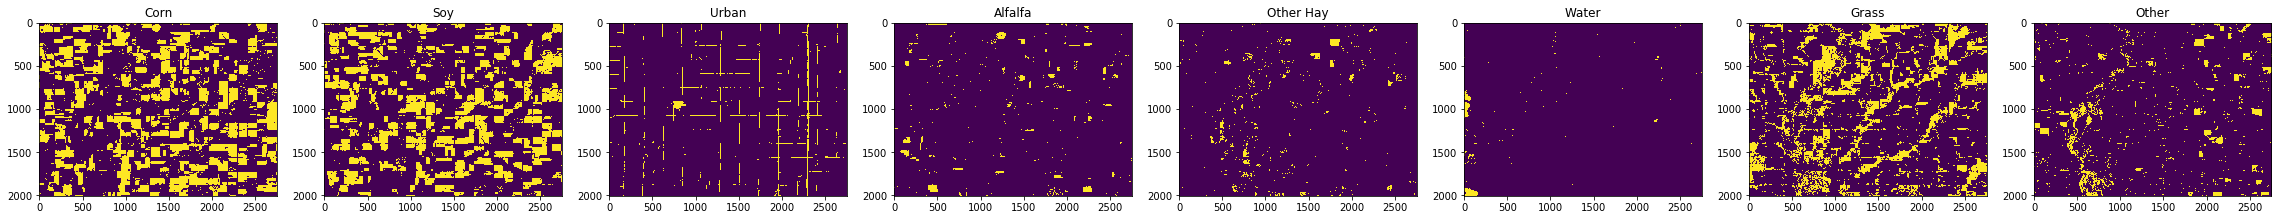

In [25]:
display_channels(new_data_y[0,:,:,:], new_data_y.shape[3], titles=titles)

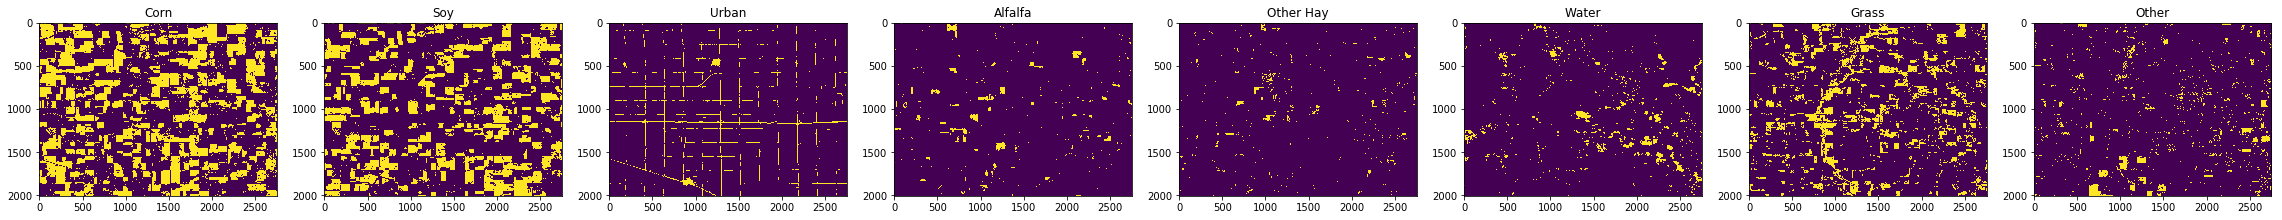

In [26]:
display_channels(new_data_y[1,:,:,:], new_data_y.shape[3], titles=titles)

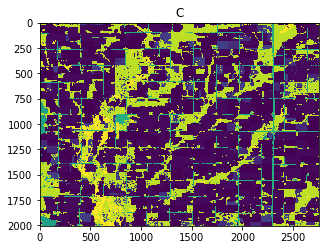

In [27]:
display_channels(data_y[0,:,:,:], data_y.shape[3], titles='Cropland')

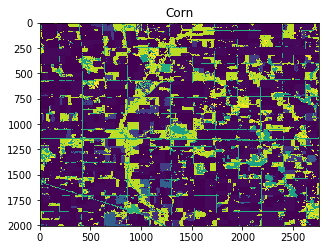

In [28]:
display_channels(data_y[1,:,:,:], data_y.shape[3], titles=titles)

In [29]:
#final piece of puts data_y to equal new data
data_y = new_data_y

## Preprocess datasets for training a Fully Connected Network (FCN)

**Normalize data**

In [30]:
def normalize_data(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data.max()
        mn = data.min()
        
        data = (data-mn)/(mx-mn)
    return data

In [31]:
data_x = normalize_data(data_x)

In [32]:
data_x.shape

(2, 2004, 2753, 6)

**Resize the images**

In [33]:
def reshape_data(data):
    size = data.shape
    new_size = []
    new_size.append(reduce(lambda x, y: x*y, size[:-1]))
    new_size.append(size[-1])
    new_size = tuple(new_size)
    return size, new_size

In [34]:
size_x, new_size_x = reshape_data(data_x)
size_y, new_size_y = reshape_data(data_y)

data_x_new = data_x.reshape(new_size_x)
data_y_new = data_y.reshape(new_size_y)

**Randomize the datasets**

In [35]:
def randomize_datasets(data_x, data_y):
    t=data_x.shape[0]
    arr_t = np.arange(t)
    np.random.shuffle(arr_t)
    data_x = data_x[arr_t,:]
    data_y = data_y[arr_t,:]
    
    return data_x, data_y

In [36]:
x_randm, y_randm = randomize_datasets(data_x_new, data_y_new)

**Training and validation sets**

In [37]:
def train_validation_split(x, y, val_size=20):
    t=x.shape[0]
    size = int(t*((100-val_size)/100))
    
    xt = x[:size,:]
    xv = x[size:,:]
    yt = y[:size,:]
    yv = y[size:,:]
    
    return xt, xv, yt, yv

In [38]:
x_train, x_validation, y_train, y_validation = train_validation_split(x_randm, y_randm)

## Define the Keras model

Here we define a neural network with two hidden layers with `relu` nonlinearities.

https://keras.io/getting-started/sequential-model-guide/

Another showing what dense is - https://github.com/keras-team/keras/issues/2645

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

#from keras.optimizers import RMSprop
#from keras.callbacks import Callback, ModelCheckpoint

# changed num_classes to howeveer many classes you set above
# set the number of epochs to 35 for full run, 1-3 for testing 
batch_size = bth
num_bands = bnd
num_classes = cls
epochs = epc
node = node
node2 = node2

model = Sequential()

#original part
model.add(Dense(node, activation = 'relu', input_shape=(num_bands,)))
model.add(Dropout(0.5))
model.add(Dense(node2, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

W0830 22:20:27.757050 139980824844032 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 22:20:27.774729 139980824844032 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 22:20:27.777532 139980824844032 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 22:20:27.792109 139980824844032 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0830 22:20:27.799890 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               3584      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 4104      
Total params: 270,344
Trainable params: 270,344
Non-trainable params: 0
_________________________________________________________________


https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc

https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/

reshaping the data suggested from the below 
https://stackoverflow.com/questions/47665391/keras-valueerror-input-0-is-incompatible-with-layer-conv2d-1-expected-ndim-4?rq=1

### Create a flow chart of the model 

In [40]:
#create a plot of the model 
#model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, axis=1)

**Compile the model**

In [41]:
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

W0830 22:20:27.880063 139980824844032 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0830 22:20:27.887423 139980824844032 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



**Train the Neural Network**

In [42]:
from keras.callbacks import Callback, ModelCheckpoint

In [43]:
# To saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath="{0}_weights.hdf5".format('FCN'), verbose=1, save_best_only=True)

In [44]:
history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_validation, y_validation), callbacks=[checkpointer])

W0830 22:20:28.013042 139980824844032 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8827219 samples, validate on 2206805 samples
Epoch 1/5
8827219/8827219 [==============================] - 496s 56us/step - loss: 1.2070 - acc: 0.5834 - val_loss: 1.3818 - val_acc: 0.4722

Epoch 00001: val_loss improved from inf to 1.38179, saving model to FCN_weights.hdf5
Epoch 2/5
8827219/8827219 [==============================] - 494s 56us/step - loss: 1.2057 - acc: 0.5888 - val_loss: 1.1620 - val_acc: 0.5883

Epoch 00002: val_loss improved from 1.38179 to 1.16197, saving model to FCN_weights.hdf5
Epoch 3/5
8827219/8827219 [==============================] - 494s 56us/step - loss: 1.2094 - acc: 0.5921 - val_loss: 1.1532 - val_acc: 0.6077

Epoch 00003: val_loss improved from 1.16197 to 1.15320, saving model to FCN_weights.hdf5
Epoch 4/5
8827219/8827219 [==============================] - 492s 56us/step - loss: 1.2138 - acc: 0.5942 - val_loss: 1.2015 - val_acc: 0.6098

Epoch 00004: val_loss did not improve from 1.15320
Epoch 5/5
8827219/8827219 [==============================] -

**Evaluate model**

In [45]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.154890972788453
Test accuracy: 0.620927086897134


# Model analysis Graphs

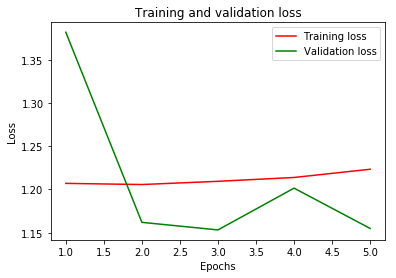

In [46]:
#Plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

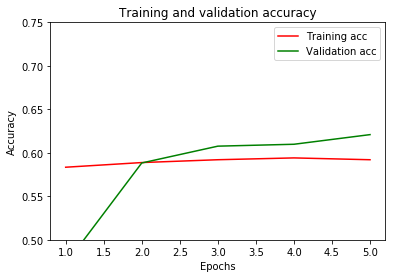

<Figure size 432x288 with 0 Axes>

In [47]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.ylim(.5,.75)
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('testplot.png')

# Confusion Matrix

In [49]:
# taken from https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras
from sklearn.metrics import confusion_matrix
Y_prediction = model.predict(x_validation)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validation,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

In [ ]:
import seaborn as sns 

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);


Useful seaborn chart examples - https://elitedatascience.com/python-seaborn-tutorial

[Text(51.0, 0.5, 'Actual'), Text(0.5, 51.0, 'Predicted')]

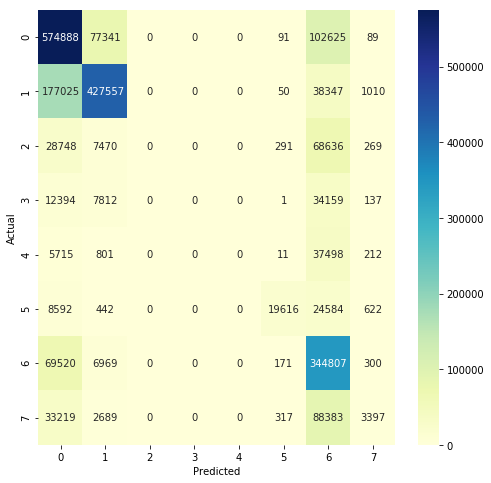

In [50]:
#plot the matrix
plt.figure(figsize=(cls,cls))
confuse = sns.heatmap(confusion_mtx, annot=True, fmt="d",cmap="YlGnBu");
confuse.set(xlabel='Predicted', ylabel='Actual')
# , vmin=0, vmax=1

**Read the weights**

In [51]:
#changed the num_classes from 4 to 6
batch_size = bth
num_bands = bnd
num_classes = cls
epochs = epc

#model = Sequential()
model = Sequential()

model.add(Dense(node, activation = 'relu', input_shape=(num_bands,)))
model.add(Dropout(0.2))
model.add(Dense(node2, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))

model.load_weights("{0}_weights.hdf5".format('FCN'))

## Predict on the test region

Test the FCN on the central region of South Dakota

In [52]:
# Central position of (AOIs) - Dell Rapids - South Dakota
point = point2

In [53]:
# buffer set to 10k - usually set to 10k - much larger area used
sentinel = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
dataset_x = sentinel.read_datasets()
cropland = ee_datasets(point = point, buffer = 10000 , startDate = startDateCrop, stopDate = stopDateCrop, scale = scale, collection = 'CroplandDataLayers')
dataset_y = cropland.read_datasets()

We select the NIR, NDVI, NDWI channels

In [54]:
#below edited from data_x = dataset_x[:,:,3:]
data_x = dataset_x
data_y = dataset_y

Sentinel 2 composite

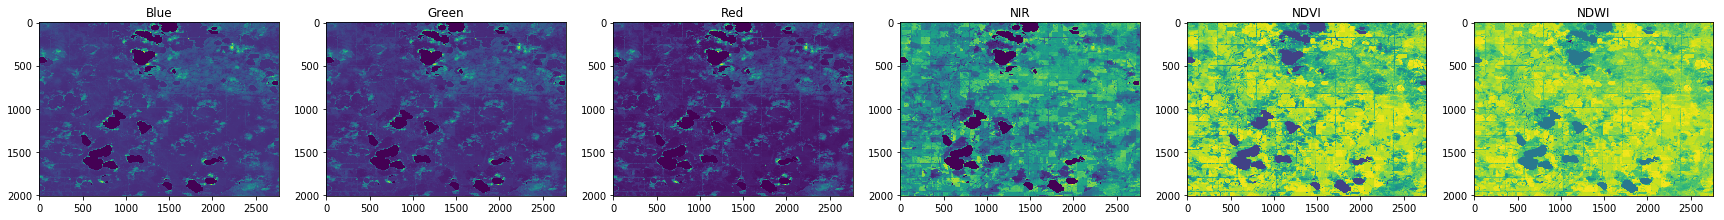

In [55]:
display_channels(data_x, data_x.shape[2], titles=titlesx)

Ground truth land cover classification

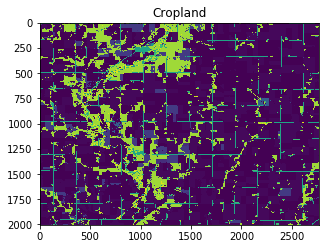

In [56]:
display_channels(data_y, data_y.shape[2], titles=['Cropland'])

**Preprocess class labels**

In [57]:
# replacing class labels again - now we have a 3D array so had to remove :, from the data_y 
new_data_y = np.copy(data_y[:,:,0])
new_data_y = replace_values(new_data_y, class_labels_1, 1000.)
new_data_y = replace_values(new_data_y, class_labels_2, 2000.)
new_data_y = replace_values(new_data_y, class_labels_3, 3000.)
new_data_y = replace_values(new_data_y, class_labels_4, 4000.)
new_data_y = replace_values(new_data_y, class_labels_5, 5000.)
new_data_y = replace_values(new_data_y, class_labels_6, 6000.)
new_data_y = replace_values(new_data_y, class_labels_7, 7000.)  
new_data_y = replace_values(new_data_y, class_labels_8, 8000.)

#Divide by 1000 and subtract 1 to get results 0 to 7
new_data_y = np.divide(new_data_y, 1000.) -1
# Convert 1-dimensional class arrays to 4-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, cls)

Output classes

In [58]:
new_data_y.shape

(2004, 2765, 8)

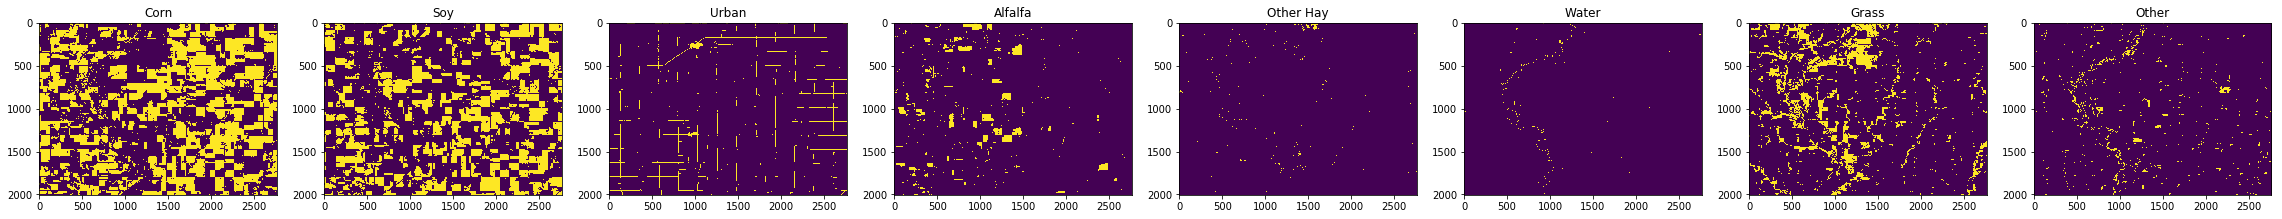

In [59]:
display_channels(new_data_y, new_data_y.shape[2], titles=titles)

**Preprocess input dataset**

In [61]:
def normalize_data(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data.max()
        mn = data.min()
        
        data = (data-mn)/(mx-mn)
    return data

In [62]:
# Normalize
data_x_norm = normalize_data(data_x)
# Resize
size_x, new_size_x = reshape_data(data_x_norm)

x_input = data_x_norm.reshape(new_size_x)

**Compute the prediction**

In [63]:
y_output = model.predict(x_input, batch_size=batch_size, verbose=0)

**Resize the output**

In [64]:
data_y_output = y_output.reshape((size_x[0], size_x[1],cls))

**Display the output**

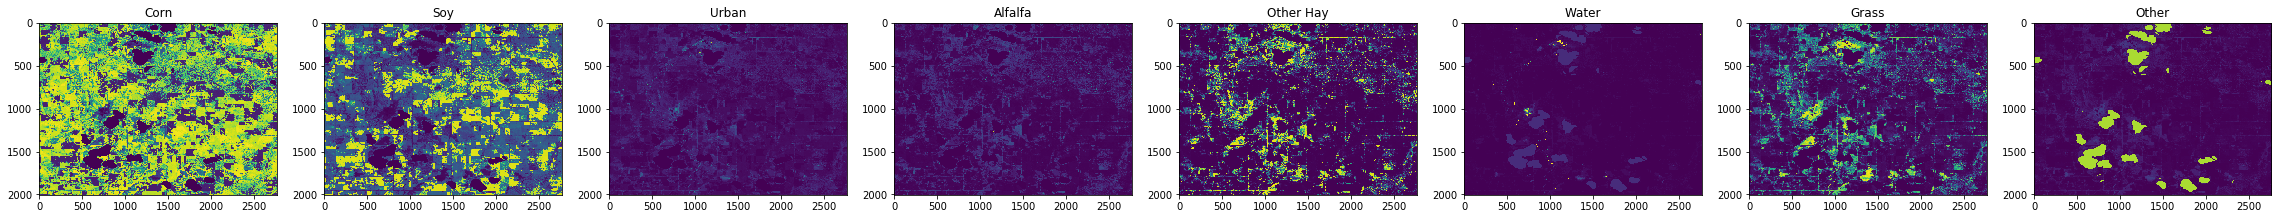

In [65]:
display_channels(data_y_output, data_y_output.shape[2], titles=titles)

We binarize the output taking the highest pixel value

In [66]:
# Binarize the output
def max_pixels(x):
    x_new = x*0
    max_val = np.amax(x, axis=2)
    size = x.shape
    for i in range(size[-1]):
        ima = x[:,:,i]*0
        ima[np.where(x[:,:,i] == max_val)] = 1
        x_new[:,:,i]= ima

    return x_new

In [67]:
data_y_output_max = max_pixels(data_y_output)

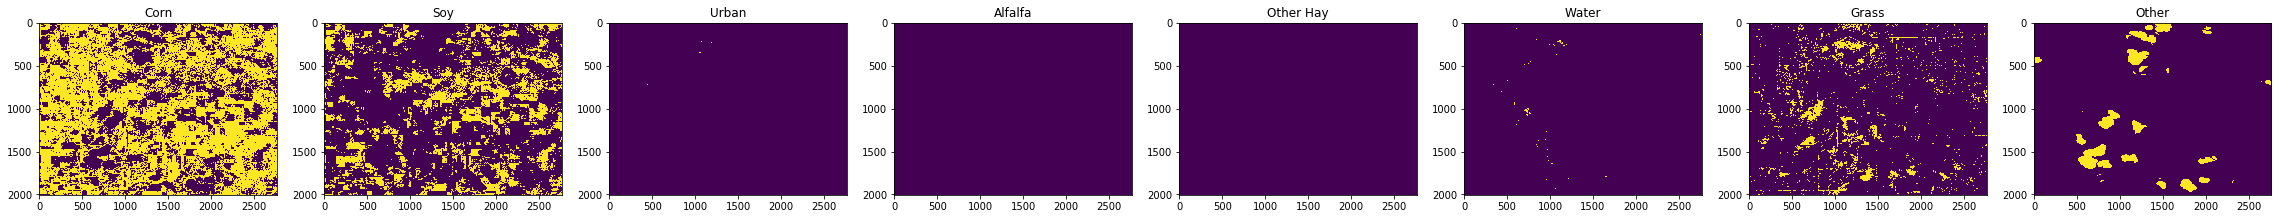

In [68]:
display_channels(data_y_output_max, data_y_output.shape[2], titles=titles)